# Scientific Computing Project :  Human activity detection - DTW and classification with preprocessing

In this project, we will try to predict human activity (1-Downstairs, 2-Jogging, 3-Sitting, 4-Standing, 5-Upstairs or 6-Walking) using smartphone sensors. That is, by using the following methods, the smartphone can detect what we are doing right now.

Using the accelerometer integrated in the smartphone, the 3-axis linear acceleration at a constant rate of 50Hz was measured. The experiments were recorded on video to label the data manually. 

<img src="files/HARDataset.JPG" width="800" height="600">

It is provided for each record in the dataset : 
- The triaxial acceleration of the accelerometer (total acceleration) and the estimated acceleration of the body. 
- Its activity label. 
- An identifier of the subject who performed the experiment.

**Dataset and description :**
https://archive.ics.uci.edu/ml/datasets/WISDM+Smartphone+et+Smartwatch+Activité+et+Biométrie+Dataset


In [8]:
import datetime
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.decomposition import PCA

!pip install fastdtw
from fastdtw import fastdtw

!pip install dtw-python
from dtw import *

In [9]:
# Dataset parameters
COLUMN_NAMES = [
    'user',
    'activity',
    'timestamp',
    'x-axis',
    'y-axis',
    'z-axis'
]

LABELS = [
    'Downstairs',
    'Jogging',
    'Sitting',
    'Standing',
    'Upstairs',
    'Walking'
]

DATA_PATH = 'dataset/WISDM_ar_v1.1_raw.txt'

# Parameter
N_CLASSES = 6
N_FEATURES = 3  # x-acceleration, y-acceleration, z-acceleration
SEGMENT_SIZE = 30 #50
TEST_SIZE = 10 #1000

## 1. Loading of both learning and test data

In [10]:
# Download data
df = pd.read_csv(DATA_PATH, header=None, names=COLUMN_NAMES)
df['z-axis'].replace({';': ''}, regex=True, inplace=True)
df = df.dropna()
df = df.reset_index(drop=True)
print(df.shape)

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]


def create_data(features, labels, chunk_size):
    new_features = []
    new_labels = []
    for i in range(len(features)):
        x, y, z = features[i]
        xs = list(chunks(x, chunk_size))
        ys = list(chunks(y, chunk_size))
        zs = list(chunks(z, chunk_size))
        for j in range(len(xs)):
            tmp = []
            if len(xs[j]) != chunk_size:
                continue
            for k in range(len(xs[j])):
                tmp.append(xs[j][k])
                tmp.append(ys[j][k])
                tmp.append(zs[j][k])
            new_features.append(tmp)
            new_labels.append(labels[i])
    d = {'features': new_features, 'labels': new_labels}
    data = pd.DataFrame(d, columns=['features', 'labels'])
    #train_size -> % of the dataset used as data train
    return train_test_split(data['features'], data['labels'], train_size=0.7)

by_ua = df.groupby(['user', 'activity'])

features = []
labels = []

for index, label in enumerate(LABELS):
    data = df[df['activity'] == label]
    x = list(data['x-axis'])
    y = list(data['y-axis'])
    z = list(data['z-axis'])
    features.append((x, y, z))
    labels.append(index)

X_train, X_test, y_train, y_test = create_data(features, labels, SEGMENT_SIZE)
print(X_train.shape, X_test.shape)


(1098203, 6)
(25622,) (10981,)


# Part I: Implementation of the Dynamic Programming Algorithm 

1. Write a DTW python function that implements the calculation and display of the cost matrix defined in TD. 

2. In order to easily adapt the calculation of the costs according to the nature of the data (and thus the distances used), write a function for each distance (Euclidean, letters, sounds) which will appear as a parameter of the DTW function.

In [11]:
def our_dtw(v, u, metric='euclidean'):
    v, u = np.atleast_2d(v, u)
    dist = scipy.spatial.distance.cdist(v.T, u.T, metric=metric)

    n, m = dist.shape
    cost = np.zeros((n, m))
    cost[0, 0] = dist[0, 0]
    for i in range(1, n):
        cost[i, 0] = cost[i - 1, 0] + dist[i, 0]
    for j in range(1, m):
        cost[0, j] = cost[0, j - 1] + dist[0, j]
    for i in range(1, n):
        for j in range(1, m):
            cost[i, j] = dist[i, j] + min(cost[i - 1, j], cost[i, j - 1], cost[i - 1, j - 1])

    n -= 1
    m -= 1
    path = []

    while (n, m) != (0, 0):
        path.append((n, m))
        n, m = min((n - 1, m), (n, m - 1), (n - 1, m - 1), key=lambda x: cost[x[0], x[1]])
    path.append((0, 0))

    return cost[-1, -1]/(n + m), path


### Application to exercises 

 Test your programs on the exercises seen in TD.

In [12]:
matA = np.array([1, 3, 4, 9, 8, 2, 1, 5, 7, 3])
matB = np.array([1, 6, 2, 3, 0, 9, 4, 3, 6, 3])
print(our_dtw(matA, matB))
print(our_dtw([[1, 9, 1, 1], [3, 8, 5, 2], [4, 2, 7, 3]],[[1, 3, 4, 4], [6, 0, 3, 0], [2, 9, 6, 1]], metric='cityblock'))


(inf, [(9, 9), (8, 8), (7, 8), (6, 7), (5, 6), (4, 5), (3, 5), (2, 4), (1, 3), (1, 2), (1, 1), (0, 0)])
(inf, [(3, 3), (2, 2), (2, 1), (1, 0), (0, 0)])


/Users/lordarian/Documents/University/Paul Sabatier/Fall20/Modeling and scientific calculation /ActionDetection/venv/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


# Part II: Physical Activity Recognition System with DTW



For each test time profile,
- Calculate for each class, the DTW score between the test time profile and the class time profiles 
- Determine the class to which you belong by minimum score on all classes

In [13]:
# Recognition system from the DTW
def predict_with_dtw(X_train, X_test, y_train, N=0):
    predicts = []
    for i, A in enumerate(X_test):
        print(i)
        t = time.perf_counter()
        closest = (np.inf, -1)
        for j, B in enumerate(X_train):
            # fastdtw
            dis = fastdtw(A, B)[0]
            # cython dtw
            # dis = dtw(A,B).distance
            # our dtw
            # dis = our_dtw(A, B)[0]
            if dis < closest[0]:
                closest = (dis, list(y_train)[j])
        predicts.append(closest[1])
        print(time.perf_counter() - t)
        if i == N - 1:
            break
    return predicts

print(str(datetime.datetime.now()))
dtw_start = time.perf_counter()
predicts = predict_with_dtw(X_train, X_test, y_train, TEST_SIZE)
dtw_time = time.perf_counter() - dtw_start
print(dtw_time)

2020-12-22 16:20:35.091577
0
8.536965224000028
1
8.59002089500001
2
8.911148962000027
3
8.810954847999994
4
8.80524761099997
5
8.784439991
6
9.786928482999997
7
10.334582175000037
8
8.49215274300002
9
8.804982311999993
89.86209499700004


## Evaluation of the results of the DTW

From the partition of the test set obtained after the DTW, calculate the confusion matrix that identifies the number of well-ranked and misranked data.

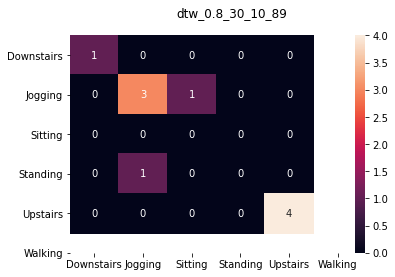

In [14]:
# Evaluation of results by confusion matrices 
cm = confusion_matrix(list(y_test)[:TEST_SIZE], predicts)
acs = accuracy_score(list(y_test)[:TEST_SIZE], predicts, normalize=True)
sns.heatmap(data=cm, fmt='.0f', xticklabels=np.unique(LABELS), yticklabels=np.unique(LABELS), annot=True)

title = '{}_{}_{}_{}_{}'.format('dtw', acs, SEGMENT_SIZE, TEST_SIZE, int(dtw_time))
plt.suptitle(title)
plt.savefig('results/{}_{}_{}_{}.png'.format('dtw', acs, SEGMENT_SIZE, TEST_SIZE, dtw_time), dpi=150, bbox_inches='tight')
plt.show()

# Part III: Comparison of dynamic programming with a classification method after data pre-processing

In this part, we will compare the results of the DTW with those of a data classification method: the k-nearest neighbors.

We will use the functions to compute PCA and kppv via the python library *scikit-learn*.

In [15]:
from sklearn.neighbors import KNeighborsClassifier

### Pre-processing by ACP

To test another classification method, 

1. From the Data_App data of the learning database and using the *PCA* function of the *scikit-learn* library, calculate the 3 main axes of the PCA by
extracting the 3 eigenvectors, noted $X_1$, $X_2$, $X_3$, associated with the 3 largest eigenvalues of the matrix of
variance-covariance $\Sigma_{App}$.These eigenvectors will constitute the new database.

2. Project the data from the learning and test database into this new database by multiplying each
vector by the base $P = [X_1X_2X_3]$.

*Note:* You can also implement PCA in
extracting the 3 eigenvectors, noted $X_1$, $X_2$, $X_3$, associated with the 3 largest eigenvalues of the matrix of
variance-covariance $\Sigma_{App}$ (by the functions *np.cov* and *np.linalg.eig*). These eigenvectors will be the new marker P. Then project the data from the training and test database into this new database by multiplying each vector by the database $P = [X_1X_2X_3]$.


### Classification by k nearest neighbors

In artificial intelligence, the k-nearest neighbor (k-nn) method is a learning method
supervised. Within this framework, a learning database is available consisting of "data-label" pairs. To estimate the output associated with a new input x, the closest k neighbor method consists in taking
(identically) the k learning samples whose input is closest to the new learning sample.
input x, according to a distance to be defined. The associated algorithm and an example (figure 1) are given below.

<img src="files/knn.jpg" width="500" height="400"  >

<img src="files/kppv.png" width="300" height="300"  >

**Example of classification by k-nn.**

 The test specimen (green circle) must be classified either in the first
class of blue squares, or in the second class of red triangles. 
If k = 3 (full circle), it is assigned to the second class because there are 2 triangles and only 1 square inside the inner circle. 
If k = 5 (dotted circle), it is assigned to the first class (3 squares versus 2 triangles inside the outer circle).

1. Using the *KNeighborsClassifier* function from the *sklearn.neighbors* library, perform a k-ppv classification based on the learning and test base you have predefined (take $k=1$).

2. Evaluate the k-ppv method by calculating the confusion matrix and the recognition rate.

3. Change the value of $k$ for k-ppv. Do you improve recognition scores?

4. Compare your results with those of the DTW.

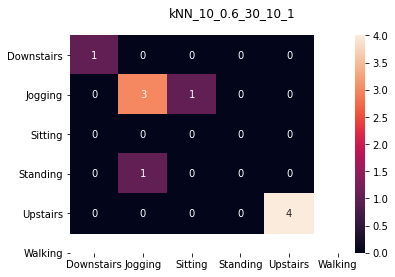

In [16]:
# Apply knn on principal components
def predict_with_knn(X_train, X_test, y_train, N=0, k=5):
    X_train = np.array(X_train.values.tolist(), dtype=np.float64)
    X_test = np.array(X_test.values.tolist(), dtype=np.float64)
    y_train = np.array(y_train.values.tolist(), dtype=np.float64)
    n_components = 3
    pca = PCA(n_components)
    PCA_train = pca.fit_transform(X_train)
    PCA_test = pca.transform(X_test[:N])

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(PCA_train, y_train)
    return knn.predict(PCA_test)

K = 10

start = time.time()
predicts = predict_with_knn(X_train, X_test, y_train, TEST_SIZE, K)
knn_time = time.time() - start
acs = accuracy_score(list(y_test)[:TEST_SIZE], predicts, normalize=True)
sns.heatmap(data=cm, fmt='.0f', xticklabels=np.unique(LABELS), yticklabels=np.unique(LABELS), annot=True)
title = '{}_{}_{}_{}_{}_{}'.format('kNN', K, acs, SEGMENT_SIZE, TEST_SIZE, int(knn_time))
plt.suptitle(title)
plt.savefig('results/{}_{}_{}_{}_{}_{}.png'.format('kNN', K, acs, SEGMENT_SIZE, TEST_SIZE, knn_time), dpi=150, bbox_inches='tight')
plt.show()